In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import numpy as np
import re, os
from string import printable
from sklearn import model_selection
from matplotlib import pyplot
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the Finale_Labeled_Dataset
Al_Boghdady_Binary_Dataset = pd.read_csv('Al_Boghdady_Binary.csv',encoding = 'unicode_escape')

In [3]:
Al_Boghdady_Binary_Dataset.shape

(5117, 2)

In [4]:
# Checking for duplicate rows or null values
Al_Boghdady_Binary_Dataset.dropna(inplace=True)
Al_Boghdady_Binary_Dataset.drop_duplicates(inplace=True)
Al_Boghdady_Binary_Dataset.shape

(4810, 2)

# Preprocessing
As you might know, most machine learning classifiers get a feature vector of fixed length as their input. So, if you’re not accustomed to NLP concepts, you may wonder how we’re going to convert unstructured textual data into a numerical array that’s going to make sense?

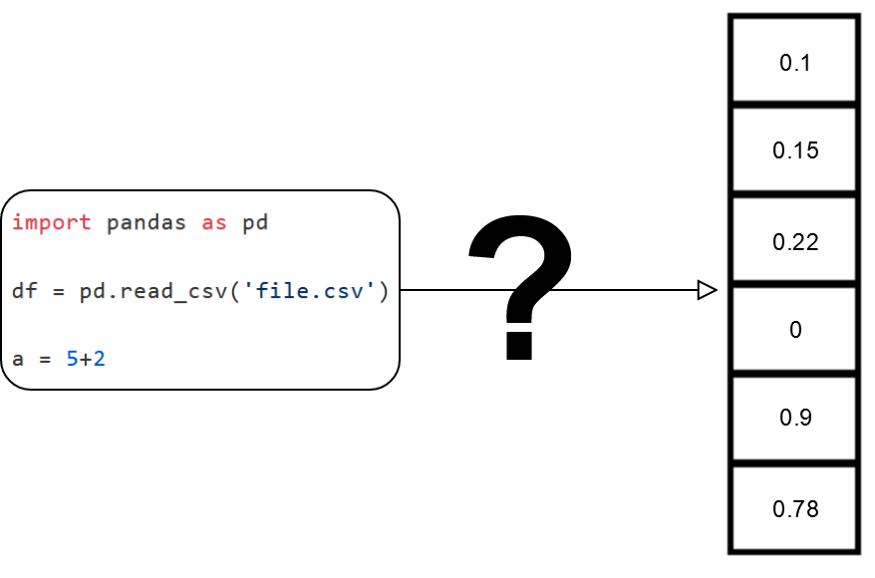

## Tokenization
**Tokenization
The first clue to vectorizing our data is Tokenization! It’s usually, the first step to every NLP project and basically consists of cutting each textual “document” (in this case, code snippets) in character substrings called Tokens.**

From these tokens, we can build a set of words (or vocabulary ) to be used for the vectorization of the text.
For regular English text, it can be just separating words with space character and punctuation (even though, this has many limitations). If you’re working on such data, packages such as nltk or spacy offer state of the art Tokenizers.

In [5]:
#Examble
from nltk.tokenize.regexp import WhitespaceTokenizer
WhitespaceTokenizer().tokenize("This is a whitespace tokenizer!")

['This', 'is', 'a', 'whitespace', 'tokenizer!']

Since we are working on source code instead of plain English text, we’re going to customize Sklearn 's tokenizer to suit our needs.
For Python code, this is the result we should expect:

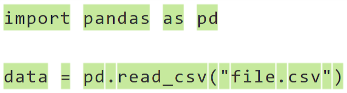

In [6]:
# Dataset split for training and testing.
Code_Snippet, Code_Tag = Al_Boghdady_Binary_Dataset.code, Al_Boghdady_Binary_Dataset.isMalicious

## cleaning-up
**delete single-character variable names or ones constituted of a sequence of the same character such as xxx**

In [7]:
# Cleaning-up
def preprocess(Code_Snippet):
    return pd.Series(Code_Snippet).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)
transformer = FunctionTransformer(preprocess)

## Vectorization
The usual next step, in a typical NLP project, is lemmatization/stemming. But since we’re dealing with code that is not a “natural” language, altering words’ structures would result in information loss. Since what we really want to do is to be able to spot discriminating keywords for each language, we’re going to directly move to Vectorization.

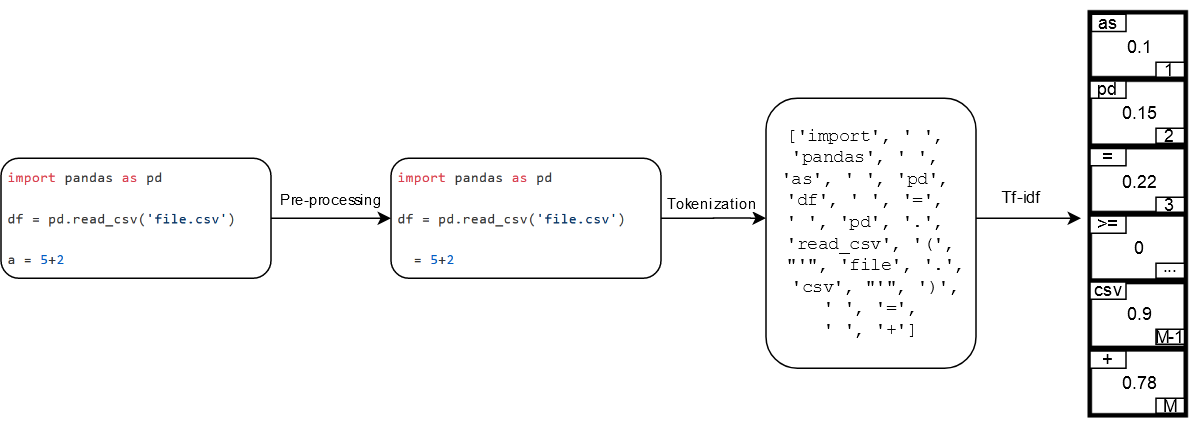

**The vector representation, we are going to go with, is called TF-IDF (term frequency-inverse document frequency) and it associates each document (source code) to an array of size M where the i-th element of the array corresponds to the scaled frequency of the token in the document.
The formula for computing the TF-IDF factor for a given token i in a document d is the following:**

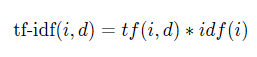

**Where TF is the term frequency and IDF the inverse document frequency.
The scale factor IDF (inverse document frequency) tries to scale down the weight associated with tokens that appear frequently across all documents such as the = operator and that, therefore, give less information on the nature of the document.**

In [8]:
token_pattern = r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])"""
vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)
Code_Snippet_train, Code_Snippet_test, Code_Tag_train, Code_Tag_test = train_test_split(Code_Snippet, Code_Tag, test_size=0.15, shuffle=True)


Now you can see that in addition to the token_pattern, we used another feature called max_features , which limits the recognized features to the top first 3000 tokens ordered by term frequency across the corpus. This serves the purpose of reducing the number of features and therefore gain in computational costs and avoid overfitting.

# Modeling 

In [9]:
#Defining the Training Model Classifier for Binary Classification

clf = RandomForestClassifier(n_jobs=4)

pipe_RF = Pipeline([
   ('preprocessing', transformer),
    ('vectorizer', vectorizer),
    ('clf', clf)]
)

##Setting of the best parameters
best_params = {
    'clf__criterion': 'gini',
    'clf__max_features': 'sqrt',
    'clf__min_samples_split': 3,
    'clf__n_estimators': 300
}

pipe_RF.set_params(**best_params)


## Fitting
pipe_RF.fit(Code_Snippet_train, Code_Tag_train)


##Evaluation of the training model
print(f'Accuracy: {pipe_RF.score(Code_Snippet_test, Code_Tag_test)}')


Accuracy: 0.9916897506925207


In [10]:
pred = pipe_RF.predict(Code_Snippet_test)

In [11]:
pred

array(['Vulnerable Code', 'Vulnerable Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable 

# Parameters tuning
We want our classification model to have as good a performance as possible. For this reason, we will be performing a grid search to optimize the model’s hyperparameters:

In [12]:
## Defining the training model classifier
#from sklearn.model_selection import GridSearchCV
#clf = RandomForestClassifier(n_jobs=4)

##RandomForest parameters
#param_grid_RF = {"clf__n_estimators" : [80, 90, 100, 110, 120, 130, 140, 150],
  #               "clf__criterion" : ["gini", "entropy"], 
   #              "clf__min_samples_split" : [2, 3], 
    #             "clf__max_features" : ["sqrt", None, "log2"]
     #           }

#### Grid search on Random Forest
#pipe_RF = Pipeline([('preprocessing', transformer),
 #                  ('vectorizer', vectorizer),
 #                  ('clf', clf)])
#grid_search_RF = GridSearchCV(pipe_RF, param_grid=param_grid_RF, cv=3)
#grid_search_RF.fit(Code_Snippet_train, Code_Tag_train)

## Print the best parameters 
#best_params = grid_search_RF.best_params_
#best_params

Accuracy: 0.983402489626556
-------------------------------------------
Accuracy: 0.995850622406639
-------------------------------------------
Accuracy: 0.991701244813278
-------------------------------------------
Accuracy: 0.995850622406639
-------------------------------------------
Accuracy: 0.991701244813278
-------------------------------------------
Accuracy: 1.0
-------------------------------------------
Accuracy: 0.991701244813278
-------------------------------------------
Accuracy: 0.991701244813278
-------------------------------------------
Accuracy: 0.995850622406639
-------------------------------------------
Accuracy: 0.991701244813278
-------------------------------------------
Accuracy: 0.9791666666666666
-------------------------------------------
Accuracy: 0.9708333333333333
-------------------------------------------
Accuracy: 0.9875
-------------------------------------------
Accuracy: 1.0
-------------------------------------------
Accuracy: 1.0
---------------

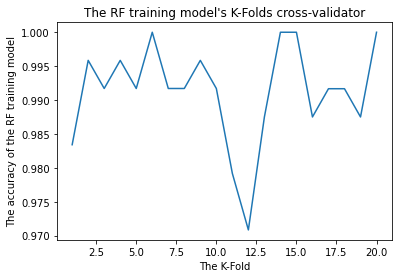

The mean accuracy of RF training model  0.9912646957123098


In [13]:
#Random Forest Training Model for Binary Classification
Al_Boghdady_Binary_Dataset.shape
Code_Snippet_Features = Al_Boghdady_Binary_Dataset.code
Code_Snippet_Tags = Al_Boghdady_Binary_Dataset.isMalicious

Scores = []

kf = KFold(n_splits=20, random_state=None, shuffle=True)
for train_index, test_index in kf.split(Code_Snippet_Features):
    
    Code_Snippet_train, Code_Snippet_test = Code_Snippet_Features.iloc[train_index], Code_Snippet_Features.iloc[test_index]
    Code_Tag_train, Code_Tag_test = Code_Snippet_Tags.iloc[train_index], Code_Snippet_Tags.iloc[test_index]
           
    #print("TRAIN:", train_index, "TEST:", test_index)
    #print("Sample TRAIN:",Code_Snippet_Features,"Sample TEST:",Code_Snippet_Tags)
    #print("Sample test TRAIN:",Code_Snippet_test,"Sample Test TEST:",Code_Tag_test)
        
    clf = RandomForestClassifier(n_jobs=4)
    pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', vectorizer),
    ('clf', clf)]
     )
    
    # Setting best params
    best_params = {'clf__criterion': 'gini',
    'clf__max_features': None,
    'clf__min_samples_split': 2,
    'clf__n_estimators': 110}
    pipe_RF.set_params(**best_params)
    
    # Fitting
    pipe_RF.fit(Code_Snippet_train, Code_Tag_train)
    
    # Evaluation
    print(f'Accuracy: {pipe_RF.score(Code_Snippet_test, Code_Tag_test)}')
    Scores.append(pipe_RF.score(Code_Snippet_test, Code_Tag_test))
    print("-------------------------------------------" )
    
# x axis values
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# corresponding y axis values
y = Scores
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('The K-Fold')
# naming the y axis
plt.ylabel('The accuracy of the RF training model')
  
# giving a title to my graph
plt.title("The RF training model's K-Folds cross-validator")
  
# function to show the plot
plt.show()

print("The mean accuracy of RF training model ", np.mean(Scores))



In [14]:
#RF Prediction Model for Multi-Class Classification
# Reading the TinyOS unlabeled Dataset
TinyOS_unlabeled_Dataset = pd.read_csv('Tinyos_Evaluation.CSV',encoding = 'unicode_escape')
TinyOS_Code_Snippet = TinyOS_unlabeled_Dataset.code

def preprocess(TinyOS_Code_Snippet):
    return pd.Series(TinyOS_Code_Snippet).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

transformer = FunctionTransformer(preprocess)
token_pattern = r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])"""

vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)

# Print findings
print (TinyOS_Code_Snippet)
pred = pipe_RF.predict(TinyOS_Code_Snippet)
pred

0      void thread ( void* arg )   {  int s ;  for ( ...
1      void thread_main ( void* arg )   {  tosthread_...
2      sf (  )  ;  throttle.initialize (  )  ;  while...
3      int opts ( void *a ,  void *b )   {  if  ( !a ...
4      new_node ( unsigned short key ,  unsigned int ...
                             ...                        
317                                unsigned char keys ; 
318    if  ( BIT_PE ( CS -> CTL0 ,  CS_CTL0_DCORES_OF...
319    else  {  dcoConst  =  * (  ( float * )  &csInf...
320    if  ( BIT_PE ( CS -> CTL0 ,  CS_CTL0_DCORES_OF...
321    void bounceThread1_start ( void *arg )   {  me...
Name: code, Length: 322, dtype: object


array(['Benign Code', 'Benign Code', 'Benign Code', 'Benign Code',
       'Benign Code', 'Benign Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Benign Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Benign Code', 'Benign Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Benign Code', 'Benign Code',
       'Benign Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code',
       'V

In [15]:
#RF Prediction Model Accuracy
# Reading the TinyOS labeled Dataset
TinyOS_labeled_Dataset = pd.read_csv('Tinyos_Evaluation_Labled_Binary.CSV',encoding = 'unicode_escape')
TinyOS_Code_Snippet, TinyOS_Code_Tag = TinyOS_labeled_Dataset.code, TinyOS_labeled_Dataset.isMalicious

def preprocess(TinyOS_Code_Snippet):
    return pd.Series(TinyOS_Code_Snippet).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

transformer = FunctionTransformer(preprocess)
token_pattern = r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])"""

vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)



# Calculating  F1-Score for iDetect
#f1 = f1_score(TinyOS_Code_Tag, pred)
#print('F1-score of iDetect: %f' % f1)
f1 = f1_score (TinyOS_Code_Tag, pred,average = 'micro' )
print('Macro F1 score of iDetect: %f' % f1)

# Printing Classification Report for iDetect
print(classification_report(TinyOS_Code_Tag, pred))

Macro F1 score of iDetect: 0.975155
                 precision    recall  f1-score   support

    Benign Code       1.00      0.83      0.91        48
Vulnerable Code       0.97      1.00      0.99       274

       accuracy                           0.98       322
      macro avg       0.99      0.92      0.95       322
   weighted avg       0.98      0.98      0.97       322

